<a href="https://colab.research.google.com/github/c-kong-ucsf/TAGScreeningProject/blob/main/dev_consolidated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Residues:  749
Other:     0
Residues2: 749
Other2:    0
749 amino acids selected for alignment and RMSD calculation
2.327395039696388
5.561542807408106
4.219305812849976
3.878207090476452


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


NameError: ignored

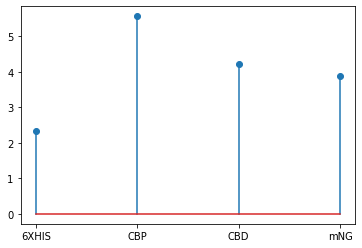

In [8]:
from google.colab import drive
drive.mount('/content/drive')

#master install block
!pip install Bio

#master import block
import Bio
from Bio import PDB
import numpy
import pandas as pd
import re
import glob 
import os
from pathlib import Path
import matplotlib.pyplot as plt

##counting residues in default pdb(w/o tags) to determine which residues to run superimposition and subsequent RMSD measurement on in biopython
parser= PDB.PDBParser()

ref_structure = parser.get_structure("reference", "rank_1/a_4f680_unrelaxed_rank_1_model_3.pdb")

model = ref_structure[0]
res_no= 0
non_resi = 0

for model in ref_structure:
    for chain in model:
        for r in chain.get_residues():
            if r.id[0] == ' ':
                res_no +=1
            else:
                non_resi +=1

print ("Residues:  %i" % (res_no))
print ("Other:     %i" % (non_resi))
res_no2 = 0
non_resi2 = 0
for model in ref_structure:
    for residue in model.get_residues():
        if PDB.is_aa(residue):
            res_no2 += 1

        else:
            non_resi2 += 1

print ("Residues2: %i" % (res_no2))
print ("Other2:    %i" % (non_resi2))
res_count= res_no
print(res_count,"amino acids selected for alignment and RMSD calculation")

##running alignment  and subsequent MRSD calculation with Biopython (note: this code block predominantly came from https://gist.github.com/andersx/6354971)

# Select what residues numbers you wish to align
# and put them in a list
start_id = 1
end_id   = res_no
atoms_to_be_aligned = range(start_id, end_id + 1)
values=[]

# for loop to iterate through tag PDB structures
for filename in os.listdir('tagged_structures'):
  f = 'tagged_structures/' + filename

  # Get the structures
  ref_structure = parser.get_structure("reference", "rank_1/a_4f680_unrelaxed_rank_1_model_3.pdb")
  sample_structure = parser.get_structure("sample",f)

  # Use the first model in the pdb-files for alignment
  # Change the number 0 if you want to align to another structure
  ref_model    = ref_structure[0]
  sample_model = sample_structure[0]

  # Make a list of the atoms (in the structures) you wish to align.
  # In this case we use CA atoms whose index is in the specified range
  ref_atoms = []
  sample_atoms = []

  # Iterate of all chains in the model in order to find all residues
  for ref_chain in ref_model:
    # Iterate of all residues in each model in order to find proper atoms
    for ref_res in ref_chain:
      # Check if residue number ( .get_id() ) is in the list
      if ref_res.get_id()[1] in atoms_to_be_aligned:
        # Append CA atom to list
        ref_atoms.append(ref_res['CA'])

  # Do the same for the sample structure
  for sample_chain in sample_model:
    for sample_res in sample_chain:
      if sample_res.get_id()[1] in atoms_to_be_aligned:
        sample_atoms.append(sample_res['CA'])

  # Now we initiate the superimposer:
  super_imposer = Bio.PDB.Superimposer()
  super_imposer.set_atoms(ref_atoms, sample_atoms)
  super_imposer.apply(sample_model.get_atoms())

  # Print RMSD:
  print(super_imposer.rms)
  values.append(super_imposer.rms)


  #a1_RMSD= super_imposer.rms

  # Save the aligned version of 1UBQ.pdb
  for i in range(1,5):      
    io = Bio.PDB.PDBIO()
    io.set_structure(sample_structure) 
    filename = "a" + str(i) + "_aligned_.pdb"
    io.save(filename)
    os.path.join("aligned/",filename)

#assembling pandas dataframe 
import pandas as pd
data=['6XHIS', 'CBP', 'CBD', 'mNG']
df = pd.DataFrame(data)
df.columns= ['tag']
#appending rmsd values to df
df['RMSD_values_proteinx']= values

#matplotlib-based plotting for tag variants of 1 protein
import matplotlib.pyplot as plt
x = df.loc[:, "tag"]
y = df.loc[:, "RMSD_values_proteinx"]

#plot
fig, ax = plt.subplots()
ax.stem(x,y)
ax.set(xlim=(0,0),xticks= np.arrange(1,5),
       ylim=(0,10), yticks= np.arrange(1,10))